In [1]:
# !pip instll python-docx

In [2]:
import os
import keyring
import warnings
warnings.filterwarnings('ignore')
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_windows')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [3]:
# Set Graph State
from typing import Annotated, List, Dict, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, AIMessage

# State definition
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    outline: Dict[str, str]
    current_section: int
    section_content: str
    section_image: str
    image_prompt: str
    total_sections: int
    full_report: List[Dict[str, str]]
    
# graph builder initialization
graph_builder = StateGraph(State)

In [4]:
# define a web search tool
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=3)

In [5]:
# 개요 작성 에이전트 설정
## 개요를 담을 Data model 선언
from pydantic import BaseModel, Field, create_model

# 사용자로부터 입력받은 전체 섹션 수에 따라 Data model의 key와 value를 정의하기 위한 함수
# create_model 함수는 pydandic data model의 이름과 key:value 값을 값을 기반으로 동적인 data model을 만들 수 있게 보조
def create_outline_model(section_count: int):
    fields = {f"section{i}":
        (str, Field(description=f"Title for section {i}")) for i in range(1, section_count + 1)}
    return create_model("DynamicOutline", **fields)

In [6]:
fields = {f"section{i}":
    (str, Field(description=f"Title for section {i}")) for i in range(1, 3+1)}

DynamicOutline = create_model("DynamicOutline", **fields)

for key, value in DynamicOutline.model_fields.items():
    print(f"key:{key}\n")
    print(f"value:{value}\n")

key:section1

value:annotation=str required=True description='Title for section 1'

key:section2

value:annotation=str required=True description='Title for section 2'

key:section3

value:annotation=str required=True description='Title for section 3'



In [7]:
DynamicOutline = create_outline_model(5)
for key, value in DynamicOutline.model_fields.items():
    print(f"key:{key}\n")
    print(f"value:{value}\n")

key:section1

value:annotation=str required=True description='Title for section 1'

key:section2

value:annotation=str required=True description='Title for section 2'

key:section3

value:annotation=str required=True description='Title for section 3'

key:section4

value:annotation=str required=True description='Title for section 4'

key:section5

value:annotation=str required=True description='Title for section 5'



In [8]:
# set LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [9]:
# Outline generation node
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def outline_generator(state: State):
    DynamicOutline = create_outline_model(state['total_sections'])
    outline_parser = JsonOutputParser(pydantic_object=DynamicOutline)
    
    outline_prompt = PromptTemplate(
        template="""Create an outline for a detailed report with exactly {section_count} main sections,
        {format_instructions}
        The topic is: {topic}""",
        input_variables=["section_count", "topic"],
        partial_variables={"format_instructions": outline_parser.get_format_instructions()},
    )
    
    chain = outline_prompt | llm | outline_parser
    
    outline = chain.invoke({
        "section_count": state["total_sections"],
        "topic": state['messages'][-1].content
    })
    return {"outline": outline}

In [ ]:
# set image-generating agent
from openai import OpenAI
from langchain_core.tools import tool

client = OpenAI()

def generate_image(prompt):
    """Generate an image using DALL-E based on the given prompt."""
    response = client.images.generate(
        model='dall-e-3',
        prompt=prompt,
        size='1024x1024',
        quality='standard',
        n=1
    )
    
    return response.data[0].url

def image_generator(state: State):
    
    prompt_template = PromptTemplate(
        template="""
        Based on the foilowing section content, create a prompt for generating an infographic that represents this section.
        
        Section content:
        
        {section_content}
        
        Image generation prompt(under 500 characters):
        """,
        input_variables=['section_content'],
    )
    
    image_prompt = llm.invoke(prompt_template.format(section_content=state['section_content']))
    image_url = generate_image(image_prompt.content)
    
    current_section = {
        "title": state['outline'][f"section{state['current_section']}"],
        "content": state['section_content'],
        "image_url": image_url,
        "image_prompt": image_prompt.content if isinstance(image_prompt, AIMessage) else image_prompt
    }
    
    updated_full_report = state.get("full_report", []) + [current_section]
    
    print(f"Completed section {state['current_section']} of {state['total_sections']}")
    
    return {
        "image_prompt": image_prompt.content if isinstance(image_prompt, AIMessage) else image_prompt,
        "section_image": image_url,
        "current_section": state["current_section"] + 1,
        "full_report": updated_full_report
    }

In [11]:
# set contents creating agent
def contents_writer(state: State):
    if "error" in state:
        return {"messages": [AIMessage(content=f"An error occurred: {state['error']}")]}
    
    if state['current_section'] > state['total_sections']:
        return {"messages": [AIMessage(content="Report completed.")]}
    
    current_section_key = f"section{state['current_section']}"
    current_topic = state['outline'][current_section_key]
    search_results = search.invoke(current_topic)
    
    previous_section_contents = []
    for i in range(1, state['current_section']):
        section_key = f"section{i}"
        if section_key in state["section_content"]:
            previous_section_contents.append(f"""
                Section {i}:
                {state['outline'][section_key]}
                {state['section_content'][section_key]}
                """)
            
    previous_sections = "\n\n".join(previous_section_contents)
    
    section_prompt = PromptTemplate(
        template=""" 
        Write a detailed section for the topic: {topic}
        
        Use the following search results for the information: {search_results}
        
        Previous sections:
        {previous_sections}
        Write only the content for this section,
        do not include any image prompts or suggestions.
        Detailed statistics or information is needed,
        so you should include collected information from search result.""",
        input_variables=['topic', 'search_result', 'previous_sections'],
    )
    
    section_content = llm.invoke(section_prompt.format(
        topic=current_topic,
        search_results=search_results,
        previous_sections=previous_sections
    ))
    
    return {
        "section_content": section_content.content,
        "current_section": state['current_section']
    }

In [ ]:
# Word generation agent
from docx import Document
from docx.shared import Inches
import requests
from io import BytesIO

def report_generator(state: State):
    doc = Document()
    doc.add_heading(f"Report: {state['messages'][0].content}", 0)
    
    for section in state['full_report']:
        doc.add_heading(section['title'], level=1)
        doc.add_paragraph(section['content'])
        
        # add images
        if section['image_url'] != "Image generation failed":
            try:
                response = requests.get(section['image_url'])
                image = BytesIO(response.content)
                doc.add_picture(image, width=Inches(6))
                doc.add_paragraph(f"Image prompt: {section['image_url']}")
            except Exception as e:
                doc.add_paragraph(f"Failed to add image: {str(e)}")
        
        doc.add_page_break()
    
    # save the report
    filename = f"report_{state['messages'][0].content}.docx".replace(" ", "_")
    doc.save(filename)
    
    return {
        "messages": [AIMessage(content=f"Report finalized and saved as {filename}")],
        "report_file": filename
    }

In [13]:
# build a graph
# add nodes
graph_builder.add_node("outline_generator", outline_generator)
graph_builder.add_node("contents_writer", contents_writer)
graph_builder.add_node("image_generator", image_generator)
graph_builder.add_node("report_generator", report_generator)

# add edges
graph_builder.add_edge(START, "outline_generator")
graph_builder.add_edge("outline_generator", "contents_writer")
graph_builder.add_edge("contents_writer", "image_generator")
graph_builder.add_edge("report_generator", END)

# add conditional edges
def should_continur_writing(state: State):
    if state['current_section'] <= state['total_sections']:
        return 'write_section'
    else:
        return 'finalize_report'
graph_builder.add_conditional_edges(
    'image_generator',
    should_continur_writing,
    {
        'write_section': "contents_writer",
        "finalize_report": "report_generator"
    }
)

# compile the graph
graph = graph_builder.compile()

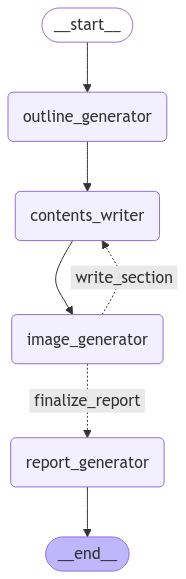

In [14]:
# plot the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [15]:
# run the graph
import os

curren_directory = os.getcwd()
print(f"current directory : {curren_directory}")

current directory : d:\projects\github\learning\llm\agent\projects


In [16]:
from langchain_core.messages import HumanMessage

# user input
topic = input("보고서 주제를 입력하세요.")
total_sections = int(input("생성할 섹션의 수를 입력하세요."))

# set initial state
initial_state = {
    "messages": [HumanMessage(content=topic)],
    "total_sections": total_sections,
    "current_section": 1,
}

# run the graph
for chunk in graph.stream(initial_state, stream_mode='updates'):
    print(chunk)
    
print("\n=== A report completed ===")

{'outline_generator': {'outline': {'section1': '한국 출산율 현황', 'section2': '출산율 감소 원인 분석', 'section3': '출산율 향상 방안'}}}
{'contents_writer': {'current_section': 1, 'section_content': '### 한국 출산율 현황\n\n한국의 출산율은 최근 몇 년간 지속적으로 감소세를 보이며 심각한 사회적 문제로 대두되고 있다. 2023년 한국의 합계출산율은 0.78명으로, 이는 세계적으로 가장 낮은 수준에 해당한다. 이러한 출산율은 국가의 경제적, 사회적 안정성에 큰 영향을 미치며, 인구 구조의 불균형을 초래할 수 있다.\n\n2023년 대한민국에서 태어난 신생아 수는 약 230,028명으로, 이는 전년 대비 감소한 수치이다. 특히, 30대 초반 여성의 출산율이 가장 높지만, 그 감소폭도 가장 큰 상황이다. 30대 초반의 연령별 출산율은 1,000명당 66.7명으로 나타났으며, 전년 대비 6.8명 감소한 것이다. 이는 한국 사회에서 결혼과 출산에 대한 가치관 변화와 경제적 부담이 가중되고 있음을 반영한다.\n\n출산율 감소의 원인으로는 연령별 출산율의 변화, 경제적 불안정, 주거 문제, 높은 교육비 등이 지적되고 있다. 특히, 많은 젊은 세대가 결혼을 미루거나 아예 포기하는 경향을 보이며, 이는 출산율에 직접적인 영향을 미치고 있다. 한국과 비교했을 때, 스페인의 출산율(1.19명)도 낮지만, 한국과의 격차는 여전히 크다.\n\n출산율 저하 문제는 국가의 지속 가능한 발전에 중대한 영향을 미치므로, 정부는 다양한 정책을 통해 출산 장려를 위한 노력을 기울이고 있다. 이러한 정책에는 육아 휴직 확대, 출산 장려금 지급, 보육 서비스 개선 등이 포함된다. 그러나 이러한 노력에도 불구하고 출산율 회복에는 한계가 있으며, 장기적인 해결책 마련이 시급한 상황이다.\n\n종합적으로, 한국의 출산율 현황은 국가의 미래를 좌우할 중요한 지표로, 이를 개선하기 위